In [57]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.tree import plot_tree
from scipy import stats

In [2]:
caminho_arquivo = './dados/MICRODADOS_ENEM_2023.csv'
data = pd.read_csv(caminho_arquivo, encoding='latin1', sep=';')
num_columns = data.shape[1]
num_rows = data.shape[0]
print(f"Número de colunas: {num_columns}")
print(f"Número de linhas: {num_rows}")
data.head()

Número de colunas: 76
Número de linhas: 3933955


,NU_INSCRICAO,NU_ANO,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,...,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,210059085136,2023,14,M,2,1,1,1,17,1,...,C,C,B,B,A,B,B,A,A,B
1,210059527735,2023,12,M,2,1,0,1,16,1,...,B,A,B,B,A,A,C,A,D,B
2,210061103945,2023,6,F,1,1,1,1,0,1,...,B,A,A,B,A,A,A,A,A,B
3,210060214087,2023,2,F,1,3,1,2,0,2,...,A,A,A,B,A,A,D,A,A,B
4,210059980948,2023,3,F,1,3,1,2,0,2,...,A,A,A,B,A,A,B,A,A,A


In [3]:
#função tratar nulos
def tratarNulos(dados):
    dataset = dados.copy()  # evita problemas de referência
    
    # Colunas numéricas que representam categorias
    colunas_categoricas_numericas = [
        'TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA',
        'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU',
        'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC','Q006',
        'Q007','Q008','Q009','Q010','Q011','Q012','Q013','Q014','Q015','Q016','Q017','Q018','Q019'
    ]
    
    for col in dataset.columns:
        if dataset[col].isnull().any():  # só trata se houver nulos
            if col in colunas_categoricas_numericas:
                # Para categóricas → moda
                moda = dataset[col].mode()
                if not moda.empty:
                    dataset[col] = dataset[col].fillna(moda.iloc[0])
            else:
                # Para numéricas contínuas → média
                media = dataset[col].mean()
                dataset[col] = dataset[col].fillna(media)
    
    return dataset

In [4]:
dados_selecionados = data[['TP_FAIXA_ETARIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO','Q006', 'Q007','Q008','Q009','Q010','Q011',
                       'Q012','Q013','Q014','Q015','Q016',
                       'Q017','Q018','Q019']]

In [5]:
print("Antes:")
print(dados_selecionados.isnull().sum()[data.isnull().sum() > 0])
dataset_sem_nulos  = tratarNulos(dados_selecionados)
print("\nDepois:")
print(dataset_sem_nulos.isnull().sum()[dataset_sem_nulos.isnull().sum() > 0])

Antes:
TP_ENSINO             2594874
TP_LOCALIZACAO_ESC    2975449
NU_NOTA_CN            1241528
NU_NOTA_CH            1111312
NU_NOTA_LC            1111312
NU_NOTA_MT            1241528
NU_NOTA_REDACAO       1111312
dtype: int64

Depois:
Series([], dtype: int64)


In [6]:
# Dicionário para mapear as respostas da questão Q006 (faixa de renda) em classes sociais
mapa_renda = {
    'A': 'D/E',
    'B': 'D/E',
    'C': 'D/E',
    'D': 'C',
    'E': 'C',
    'F': 'C',
    'G': 'C',
    'H': 'C',
    'I': 'C',
    'J': 'B',
    'K': 'B',
    'L': 'B',
    'M': 'B',
    'N': 'B',
    'O': 'B',
    'P': 'B',
    'Q': 'A'
}

# Criar nova coluna 'classe_social' baseada na resposta da questão Q006
dataset_sem_nulos['classe_social'] = dataset_sem_nulos['Q006'].map(mapa_renda)
dataset_sem_nulos = dataset_sem_nulos.drop(columns=['Q006'])

In [7]:
num_columns = dataset_sem_nulos.shape[1]
num_rows = dataset_sem_nulos.shape[0]
print(f"Número de colunas: {num_columns}")
print(f"Número de linhas: {num_rows}")
dataset_sem_nulos.head()

Número de colunas: 29
Número de linhas: 3933955


,TP_FAIXA_ETARIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,TP_LOCALIZACAO_ESC,...,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,classe_social
0,14,M,2,1,1,1,17,1,1.0,1.0,...,D,C,B,B,D,C,C,B,B,C
1,12,M,2,1,0,1,16,1,1.0,1.0,...,A,B,B,B,A,B,A,B,B,C
2,6,F,1,1,1,1,0,1,1.0,1.0,...,A,B,A,B,A,B,A,A,B,D/E
3,2,F,1,3,1,2,0,2,1.0,1.0,...,A,B,A,A,A,A,A,A,B,D/E
4,3,F,1,3,1,2,0,2,1.0,1.0,...,A,B,A,A,A,A,A,A,B,D/E


In [8]:
# 1. Separar X e y
X = dataset_sem_nulos.drop(columns=['classe_social'])
y = dataset_sem_nulos['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo = Pipeline(steps=[
    ('preprocessador', preprocessador),
    ('classificador', clf) 
])



# 6. Treinar modelo
modelo.fit(X, y)

# 7. Avaliar
y_pred = modelo.predict(X)
print("Acurácia:", accuracy_score(y, y_pred))
print("\nRelatório de classificação:\n", classification_report(y, y_pred))
print("\nMatriz de confusão:\n", confusion_matrix(y, y_pred))


Acurácia: 0.9670705435115552

Relatório de classificação:
               precision    recall  f1-score   support

           A       0.99      1.00      0.99     51489
           B       0.99      0.98      0.98    328920
           C       0.96      0.95      0.95   1389280
         D/E       0.97      0.98      0.97   2164266

    accuracy                           0.97   3933955
   macro avg       0.98      0.98      0.98   3933955
weighted avg       0.97      0.97      0.97   3933955


Matriz de confusão:
 [[  51271      63     108      47]
 [    306  322909    4588    1117]
 [    164    3559 1315209   70348]
 [     31    1145   48067 2115023]]


In [9]:
def analisar_importancia_features_agregada(modelo, clf, categoricas, top_n=None):
    """
    Exibe a importância das features de um modelo DecisionTreeClassifier,
    somando as importâncias das dummies das features categóricas.

    Parâmetros:
    - modelo: pipeline treinado (com preprocessador + classificador)
    - clf: classificador treinado (ex: DecisionTreeClassifier)
    - categoricas: lista de colunas categóricas originais
    - top_n: se quiser mostrar só as N variáveis mais importantes (opcional)

    Retorna:
    - df_agregado: DataFrame com importância agregada por feature
    """

    # Extrair nomes das features pós-transformação
    nomes_features = modelo.named_steps['preprocessador'].get_feature_names_out()
    
    # Importâncias
    importances = clf.feature_importances_
    
    # Criar DataFrame
    df = pd.DataFrame({
        'feature_expandida': nomes_features,
        'importancia': importances
    })
    
    # Inicializar coluna de feature original
    df['feature_original'] = df['feature_expandida']
    
    # Mapear dummies categóricas para a feature original
    for cat in categoricas:
        mask = df['feature_expandida'].str.contains(f"__{cat}_")
        df.loc[mask, 'feature_original'] = cat
    
    # Agregar importâncias por feature original
    df_agregado = df.groupby('feature_original')['importancia'].sum().sort_values(ascending=False)
    
    # Filtrar top_n se necessário
    if top_n:
        df_agregado = df_agregado.head(top_n)
    
    # Print em texto
    print("Importância das features (agregada):")
    for feat, imp in df_agregado.items():
        print(f"Feature {feat}: {imp:.4f}")
    
    # Gráfico
    plt.figure(figsize=(10,6))
    plt.bar(range(len(df_agregado)), df_agregado.values, align="center")
    plt.xticks(range(len(df_agregado)), df_agregado.index, rotation=90)
    plt.title("Importância das Features (DecisionTreeClassifier)")
    plt.tight_layout()
    plt.show()
    
    return df_agregado

In [ ]:
def analisar_desempenho_por_classe(dataset, notas=['NU_NOTA_CH','NU_NOTA_CN','NU_NOTA_LC','NU_NOTA_MT','NU_NOTA_REDACAO'], salvar_fig=False, nome_fig_prefixo="desempenho"):
    """
    Analisa estatísticas das notas por classe social, incluindo média, mediana, moda,
    desvio padrão, variância, amplitude e coeficiente de variação.
    """

    # Criar coluna de média das notas
    dataset['media_notas'] = dataset[notas].mean(axis=1)

    # Funções auxiliares
    def calc_amplitude(x):
        return x.max() - x.min()
    
    def calc_cv(x):
        return (x.std() / x.mean()) * 100 if x.mean() != 0 else np.nan

    # Agrupar por classe social
    resumo = dataset.groupby('classe_social')['media_notas'].agg(
        media='mean',
        mediana='median',
        desvio_padrao='std',
        variancia='var',
        amplitude=calc_amplitude,
        coef_var=calc_cv
    ).reset_index()

    # Imprimir tabela
    print("\nResumo estatístico completo por classe social:")
    print(resumo)

    # Gráfico: média ± desvio padrão
    plt.figure(figsize=(10,6))
    plt.bar(resumo['classe_social'], resumo['media'], yerr=resumo['desvio_padrao'], capsize=5, color='skyblue')
    plt.xlabel("Classe Social")
    plt.ylabel("Média das notas")
    plt.title("Média e Desvio Padrão das Notas por Classe Social")
    plt.show()

    return resumo

Importância das features (agregada):
Feature Q010: 0.2168
Feature num__NU_NOTA_MT: 0.0954
Feature num__NU_NOTA_LC: 0.0850
Feature num__NU_NOTA_CH: 0.0847
Feature num__NU_NOTA_CN: 0.0803
Feature num__NU_NOTA_REDACAO: 0.0552
Feature Q014: 0.0425
Feature num__TP_FAIXA_ETARIA: 0.0414
Feature Q008: 0.0401
Feature Q007: 0.0348
Feature num__TP_ANO_CONCLUIU: 0.0250
Feature num__TP_COR_RACA: 0.0246
Feature Q009: 0.0202
Feature Q019: 0.0182
Feature Q018: 0.0181
Feature Q011: 0.0169
Feature Q013: 0.0165
Feature TP_SEXO: 0.0137
Feature num__TP_ESTADO_CIVIL: 0.0134
Feature Q016: 0.0124


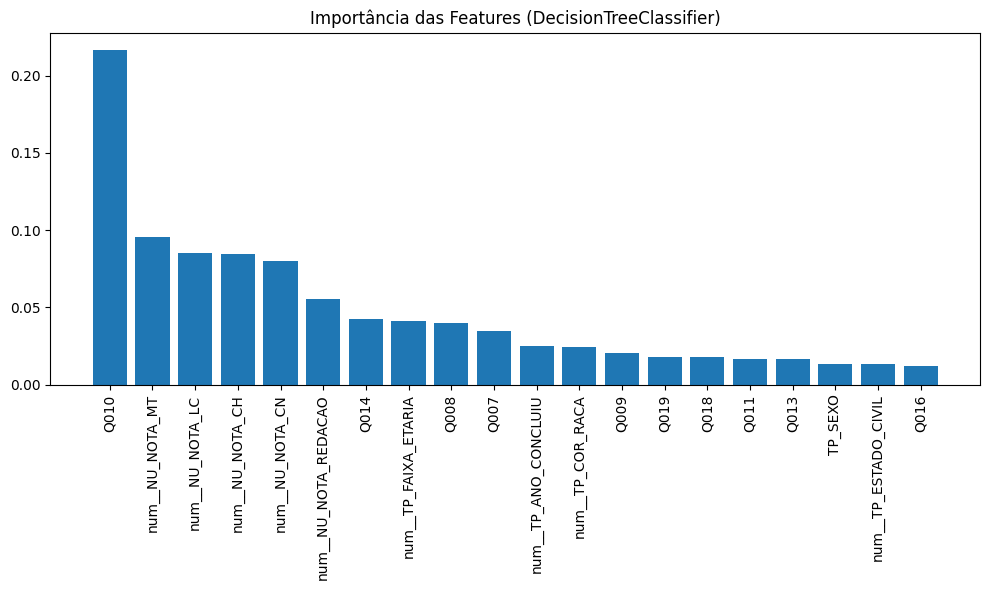

In [10]:
df_importancia = analisar_importancia_features_agregada(modelo, clf, categoricas, 20)


In [11]:
def analisar_quartis_por_classe(dataset):
    """
    Função para analisar a distribuição da classe social em cada quartil de notas.
    
    Parâmetros:
        dataset (pd.DataFrame): dataset com colunas 'NU_NOTA_CN', 'NU_NOTA_CH',
                                'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO' e 'classe_social'.
    
    Retorno:
        pd.DataFrame: tabela com distribuição percentual da classe social por quartil de notas.
    """

    # Cria uma coluna com a média das notas
    dataset['media_notas'] = dataset[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
                                      'NU_NOTA_MT', 'NU_NOTA_REDACAO']].mean(axis=1)

    # Divide em quartis
    dataset['quartil_notas'] = pd.qcut(dataset['media_notas'], 4, 
                                       labels=['1º Quartil (mais baixo)', 
                                               '2º Quartil', 
                                               '3º Quartil', 
                                               '4º Quartil (mais alto)'])

    # Calcula a distribuição percentual
    tabela = (dataset.groupby('quartil_notas')['classe_social']
                     .value_counts(normalize=True)
                     .rename('proporcao')
                     .reset_index())

    # Transforma em tabela no formato que você mostrou
    tabela_pivot = tabela.pivot(index='quartil_notas', 
                                columns='classe_social', 
                                values='proporcao')

    print("\nDistribuição de classe social por quartil de notas:\n")
    print(tabela_pivot)

    return tabela_pivot

In [12]:
def analisar_quartis_com_modelo(modelo, X):
    # Faz as previsões
    y_pred = modelo.predict(X)

    # Cria DataFrame com notas + previsão
    df = X.copy()
    df['classe_prevista'] = y_pred
    df['media_notas'] = X[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
                           'NU_NOTA_MT', 'NU_NOTA_REDACAO']].mean(axis=1)

    # Divide em quartis
    df['quartil_notas'] = pd.qcut(df['media_notas'], 4,
                                  labels=['1º Quartil (mais baixo)',
                                          '2º Quartil',
                                          '3º Quartil',
                                          '4º Quartil (mais alto)'])

    # Tabela de distribuição
    tabela = (df.groupby('quartil_notas')['classe_prevista']
                .value_counts(normalize=True)
                .rename('proporcao')
                .reset_index())

    tabela_pivot = tabela.pivot(index='quartil_notas',
                                columns='classe_prevista',
                                values='proporcao')

    print("\nDistribuição da classe prevista pelo modelo em cada quartil de notas:\n")
    print(tabela_pivot)

    return tabela_pivot

In [13]:
resultado_quartis_dataset_geral = analisar_quartis_por_classe(dataset_sem_nulos)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = (dataset.groupby('quartil_notas')['classe_social']



Distribuição de classe social por quartil de notas:

classe_social                   A         B         C       D/E
quartil_notas                                                  
1º Quartil (mais baixo)  0.002955  0.027005  0.256782  0.713257
2º Quartil               0.006063  0.043390  0.315187  0.635361
3º Quartil               0.009734  0.080390  0.427948  0.481928
4º Quartil (mais alto)   0.035744  0.205236  0.478425  0.280595


In [ ]:
resultado_modelo = analisar_quartis_com_modelo(modelo, X)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\92591484.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = (df.groupby('quartil_notas')['classe_prevista']



Distribuição da classe prevista pelo modelo em cada quartil de notas:

classe_prevista                 A         B         C       D/E
quartil_notas                                                  
1º Quartil (mais baixo)  0.002955  0.027005  0.256786  0.713253
2º Quartil               0.006244  0.042590  0.301496  0.649669
3º Quartil               0.009734  0.080390  0.427948  0.481928
4º Quartil (mais alto)   0.035744  0.205236  0.478425  0.280595



Resumo estatístico completo por classe social:
  classe_social       media     mediana        moda  desvio_padrao  \
0             A  624.727161  631.860000  537.777315      87.895092   
1             B  606.098855  606.720000  537.777315      85.356606   
2             C  554.888060  537.777315  537.777315      77.782325   
3           D/E  514.341703  537.777315  537.777315      70.461343   

     variancia  amplitude   coef_var  
0  7725.547248     792.52  14.069357  
1  7285.750136     847.26  14.082951  
2  6050.090076     862.58  14.017661  
3  4964.800828     840.26  13.699325  


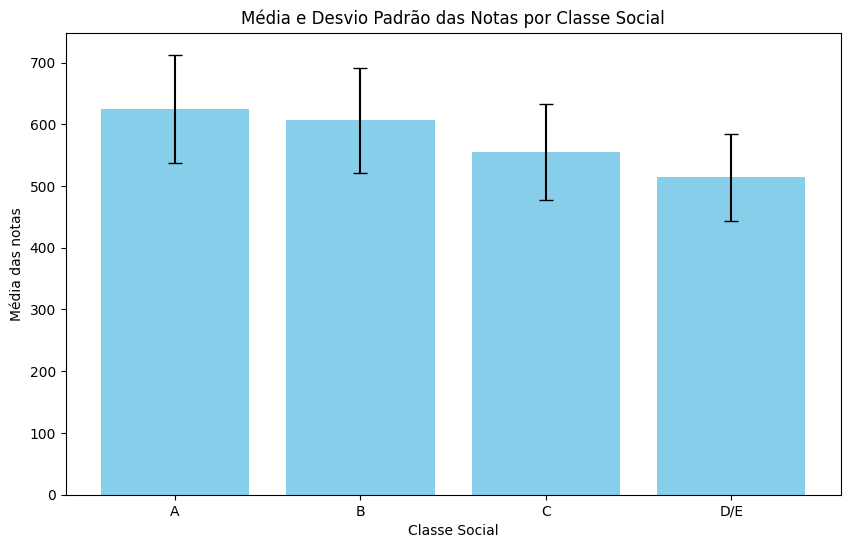

,classe_social,media,mediana,moda,desvio_padrao,variancia,amplitude,coef_var
0,A,624.727161,631.860000,537.777315,87.895092,7725.547248,792.52,14.069357
1,B,606.098855,606.720000,537.777315,85.356606,7285.750136,847.26,14.082951
2,C,554.888060,537.777315,537.777315,77.782325,6050.090076,862.58,14.017661
3,D/E,514.341703,537.777315,537.777315,70.461343,4964.800828,840.26,13.699325


In [61]:
analisar_desempenho_por_classe(dataset_sem_nulos)

In [15]:
# Filtrar apenas escolas urbanas
dataset_urbano = dataset_sem_nulos[dataset_sem_nulos['TP_LOCALIZACAO_ESC'] == 1]

# Filtrar apenas escolas rurais
dataset_rural = dataset_sem_nulos[dataset_sem_nulos['TP_LOCALIZACAO_ESC'] == 2]

In [16]:
# 1. Separar X e y
X_urbano = dataset_urbano.drop(columns=['classe_social'])
y_urbano = dataset_urbano['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_urbano = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_urbano = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_urbano = Pipeline(steps=[
    ('preprocessador', preprocessador_urbano),
    ('classificador', clf_urbano) 
])



# 6. Treinar modelo
modelo_urbano.fit(X_urbano, y_urbano)

# 7. Avaliar
y_pred_urbano = modelo_urbano.predict(X_urbano)
print("Acurácia:", accuracy_score(y_urbano, y_pred_urbano))
print("\nRelatório de classificação:\n", classification_report(y_urbano, y_pred_urbano))
print("\nMatriz de confusão:\n", confusion_matrix(y_urbano, y_pred_urbano))


Acurácia: 0.9668422558009186

Relatório de classificação:
               precision    recall  f1-score   support

           A       0.99      1.00      0.99     51421
           B       0.99      0.98      0.98    327895
           C       0.96      0.95      0.95   1380376
         D/E       0.97      0.98      0.97   2138613

    accuracy                           0.97   3898305
   macro avg       0.98      0.98      0.98   3898305
weighted avg       0.97      0.97      0.97   3898305


Matriz de confusão:
 [[  51203      63     108      47]
 [    306  321886    4588    1115]
 [    164    3557 1306458   70197]
 [     31    1144   47939 2089499]]


In [17]:
resultado_quartis_dataset_urbano = analisar_quartis_por_classe(dataset_urbano)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['quartil_notas'] = pd.qcut(dataset['media_notas'], 4,
C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:25: FutureWarning: The default of observed=False is deprecated and will be changed


Distribuição de classe social por quartil de notas:

classe_social                   A         B         C       D/E
quartil_notas                                                  
1º Quartil (mais baixo)  0.002979  0.027229  0.258085  0.711707
2º Quartil               0.006106  0.043686  0.316235  0.633973
3º Quartil               0.009827  0.080905  0.428596  0.480672
4º Quartil (mais alto)   0.036007  0.206201  0.478582  0.279210


In [18]:
resultado_modelo_urbano = analisar_quartis_com_modelo(modelo_urbano, X_urbano)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\92591484.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = (df.groupby('quartil_notas')['classe_prevista']



Distribuição da classe prevista pelo modelo em cada quartil de notas:

classe_prevista                 A         B         C       D/E
quartil_notas                                                  
1º Quartil (mais baixo)  0.002979  0.027229  0.258089  0.711703
2º Quartil               0.006290  0.042877  0.302405  0.648428
3º Quartil               0.009827  0.080905  0.428596  0.480672
4º Quartil (mais alto)   0.036007  0.206201  0.478582  0.279210


C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\2365023038.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social:
  classe_social       media     mediana        moda  desvio_padrao  \
0             A  624.830056  631.980000  537.777315      87.856635   
1             B  606.161306  606.780000  537.777315      85.365343   
2             C  554.966019  537.777315  537.777315      77.761828   
3           D/E  514.521983  537.777315  537.777315      70.347372   

     variancia  amplitude   coef_var  
0  7718.788346     792.52  14.060885  
1  7287.241745     847.26  14.082942  
2  6046.901935     862.58  14.011998  
3  4948.752724     840.26  13.672374  


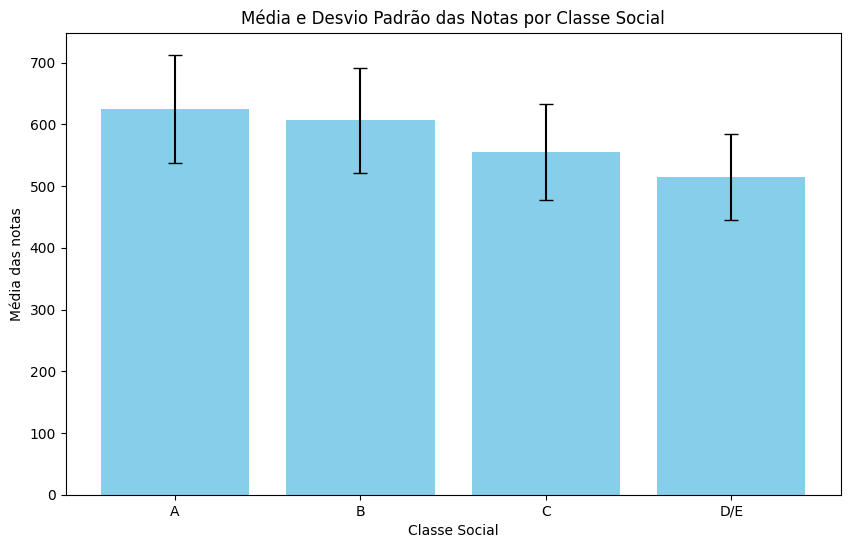

,classe_social,media,mediana,moda,desvio_padrao,variancia,amplitude,coef_var
0,A,624.830056,631.980000,537.777315,87.856635,7718.788346,792.52,14.060885
1,B,606.161306,606.780000,537.777315,85.365343,7287.241745,847.26,14.082942
2,C,554.966019,537.777315,537.777315,77.761828,6046.901935,862.58,14.011998
3,D/E,514.521983,537.777315,537.777315,70.347372,4948.752724,840.26,13.672374


In [62]:
analisar_desempenho_por_classe(dataset_urbano)

Importância das features (agregada):
Feature Q010: 0.2165
Feature num__NU_NOTA_MT: 0.0953
Feature num__NU_NOTA_LC: 0.0851
Feature num__NU_NOTA_CH: 0.0850
Feature num__NU_NOTA_CN: 0.0808
Feature num__NU_NOTA_REDACAO: 0.0553
Feature Q014: 0.0425
Feature num__TP_FAIXA_ETARIA: 0.0414
Feature Q008: 0.0401
Feature Q007: 0.0350
Feature num__TP_ANO_CONCLUIU: 0.0252
Feature num__TP_COR_RACA: 0.0246
Feature Q009: 0.0202
Feature Q019: 0.0182
Feature Q018: 0.0181
Feature Q011: 0.0169
Feature Q013: 0.0165
Feature TP_SEXO: 0.0138
Feature num__TP_ESTADO_CIVIL: 0.0135
Feature Q016: 0.0124


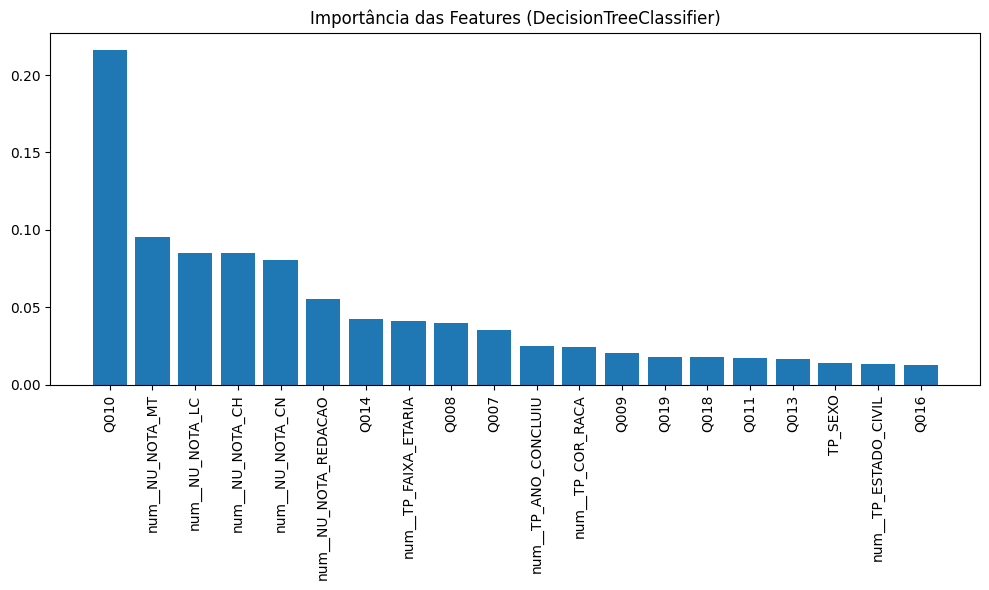

In [63]:
df_importancia_urbano = analisar_importancia_features_agregada(modelo_urbano, clf_urbano, categoricas, 20)

In [20]:
# 1. Separar X e y
X_rural = dataset_rural.drop(columns=['classe_social'])
y_rural = dataset_rural['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_rural = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_rural = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_rural = Pipeline(steps=[
    ('preprocessador', preprocessador_rural),
    ('classificador', clf_rural) 
])



# 6. Treinar modelo
modelo_rural.fit(X_rural, y_rural)

# 7. Avaliar
y_pred_rural = modelo_rural.predict(X_rural)
print("Acurácia:", accuracy_score(y_rural, y_pred_rural))
print("\nRelatório de classificação:\n", classification_report(y_rural, y_pred_rural))
print("\nMatriz de confusão:\n", confusion_matrix(y_rural, y_pred_rural))


Acurácia: 0.9920336605890603

Relatório de classificação:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00        68
           B       1.00      1.00      1.00      1025
           C       0.99      0.98      0.98      8904
         D/E       0.99      0.99      0.99     25653

    accuracy                           0.99     35650
   macro avg       0.99      0.99      0.99     35650
weighted avg       0.99      0.99      0.99     35650


Matriz de confusão:
 [[   68     0     0     0]
 [    0  1023     0     2]
 [    0     2  8751   151]
 [    0     1   128 25524]]


In [21]:
resultado_quartis_dataset_rural = analisar_quartis_por_classe(dataset_rural)


Distribuição de classe social por quartil de notas:

classe_social                   A         B         C       D/E
quartil_notas                                                  
1º Quartil (mais baixo)  0.001346  0.007853  0.148530  0.842271
2º Quartil               0.001717  0.014595  0.205300  0.778388
3º Quartil               0.002841  0.022727  0.315341  0.659091
4º Quartil (mais alto)   0.002805  0.077648  0.435592  0.483954


C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['quartil_notas'] = pd.qcut(dataset['media_notas'], 4,
C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:25: FutureWarning: The default of observed=False is deprecated and will be changed

In [22]:
resultado_modelo_rural = analisar_quartis_com_modelo(modelo_rural, X_rural)


Distribuição da classe prevista pelo modelo em cada quartil de notas:

classe_prevista                 A         B         C       D/E
quartil_notas                                                  
1º Quartil (mais baixo)  0.001346  0.007853  0.148530  0.842271
2º Quartil               0.001717  0.014652  0.203869  0.779762
3º Quartil               0.002841  0.022727  0.315341  0.659091
4º Quartil (mais alto)   0.002805  0.077648  0.435592  0.483954


C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\92591484.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = (df.groupby('quartil_notas')['classe_prevista']



Resumo estatístico completo por classe social:
  classe_social       media     mediana        moda  desvio_padrao  \
0             A  546.919173  537.777315  537.777315      82.918582   
1             B  586.121025  588.080000  537.777315      80.090489   
2             C  542.802090  537.777315  537.777315      79.987805   
3           D/E  499.312258  537.777315  537.777315      77.937957   

     variancia  amplitude   coef_var  
0  6875.491272  386.70255  15.161030  
1  6414.486389  574.72000  13.664497  
2  6398.048928  680.92000  14.736090  
3  6074.325089  621.90000  15.609061  


C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\2365023038.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)


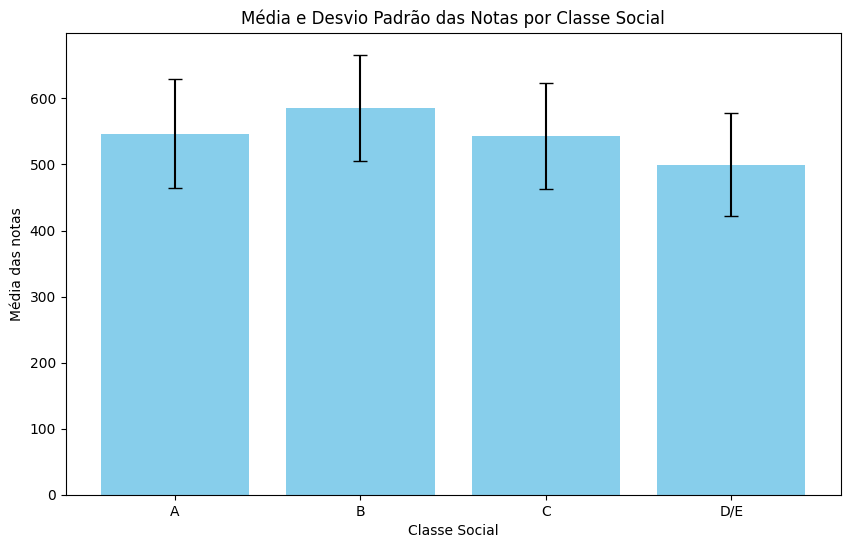

,classe_social,media,mediana,moda,desvio_padrao,variancia,amplitude,coef_var
0,A,546.919173,537.777315,537.777315,82.918582,6875.491272,386.70255,15.161030
1,B,586.121025,588.080000,537.777315,80.090489,6414.486389,574.72000,13.664497
2,C,542.802090,537.777315,537.777315,79.987805,6398.048928,680.92000,14.736090
3,D/E,499.312258,537.777315,537.777315,77.937957,6074.325089,621.90000,15.609061


In [64]:
analisar_desempenho_por_classe(dataset_rural)

Importância das features (agregada):
Feature Q010: 0.2561
Feature num__NU_NOTA_MT: 0.0906
Feature num__NU_NOTA_CH: 0.0818
Feature num__NU_NOTA_LC: 0.0817
Feature num__NU_NOTA_CN: 0.0754
Feature num__NU_NOTA_REDACAO: 0.0598
Feature Q014: 0.0472
Feature num__TP_FAIXA_ETARIA: 0.0330
Feature Q008: 0.0315
Feature Q009: 0.0302
Feature Q011: 0.0298
Feature num__TP_COR_RACA: 0.0293
Feature Q019: 0.0235
Feature Q013: 0.0224
Feature TP_SEXO: 0.0207
Feature Q018: 0.0144
Feature Q015: 0.0139
Feature Q016: 0.0139
Feature Q007: 0.0110
Feature Q012: 0.0094


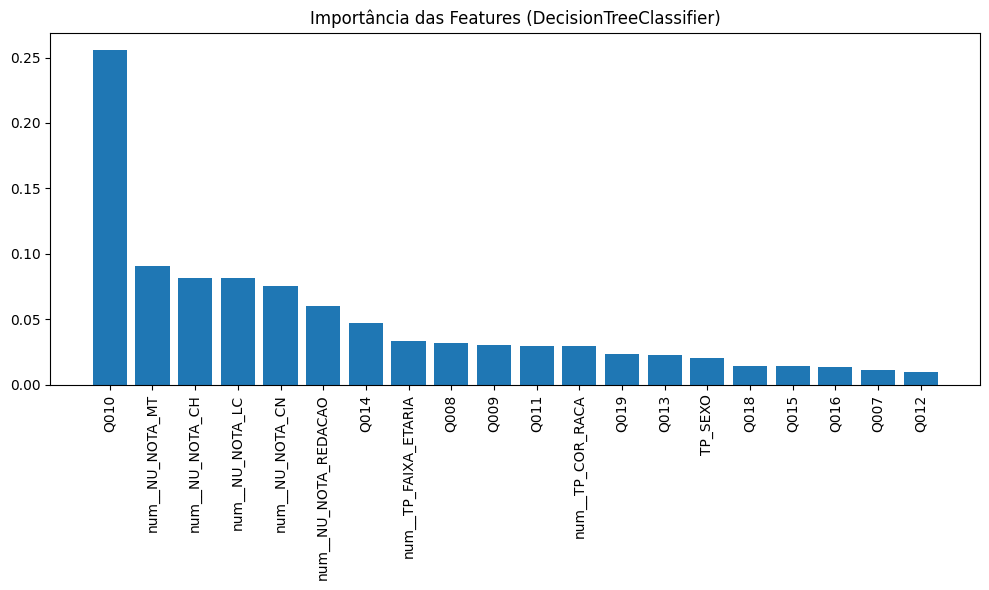

In [23]:
df_importancia_rural = analisar_importancia_features_agregada(modelo_rural,clf_rural, categoricas, top_n=20)

In [31]:
# Filtrar apenas homens
dataset_homem = dataset_sem_nulos[dataset_sem_nulos['TP_SEXO'] == "M"]

# Filtrar apenas mulheres
dataset_mulher = dataset_sem_nulos[dataset_sem_nulos['TP_SEXO'] == "F"]

In [25]:
# 1. Separar X e y
X_homem = dataset_homem.drop(columns=['classe_social'])
y_homem = dataset_homem['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_homem = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_homem = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_homem = Pipeline(steps=[
    ('preprocessador', preprocessador_homem),
    ('classificador', clf_homem) 
])



# 6. Treinar modelo
modelo_homem.fit(X_homem, y_homem)

# 7. Avaliar
y_pred_homem = modelo_homem.predict(X_homem)
print("Acurácia:", accuracy_score(y_homem, y_pred_homem))
print("\nRelatório de classificação:\n", classification_report(y_homem, y_pred_homem))
print("\nMatriz de confusão:\n", confusion_matrix(y_homem, y_pred_homem))

Acurácia: 0.965867465211424

Relatório de classificação:
               precision    recall  f1-score   support

           A       0.99      1.00      0.99     26345
           B       0.98      0.98      0.98    153491
           C       0.96      0.95      0.96    592796
         D/E       0.97      0.97      0.97    750138

    accuracy                           0.97   1522770
   macro avg       0.98      0.98      0.98   1522770
weighted avg       0.97      0.97      0.97   1522770


Matriz de confusão:
 [[ 26233     31     55     26]
 [   148 150694   2140    509]
 [    84   1869 565199  25644]
 [    18    558  20894 728668]]


Importância das features (agregada):
Feature Q010: 0.1965
Feature num__NU_NOTA_MT: 0.0939
Feature num__NU_NOTA_LC: 0.0857
Feature num__NU_NOTA_CH: 0.0842
Feature num__NU_NOTA_CN: 0.0815
Feature num__NU_NOTA_REDACAO: 0.0572
Feature num__TP_FAIXA_ETARIA: 0.0461
Feature Q014: 0.0418
Feature Q008: 0.0392
Feature Q007: 0.0390
Feature num__TP_COR_RACA: 0.0282
Feature num__TP_ANO_CONCLUIU: 0.0280
Feature Q009: 0.0237
Feature Q019: 0.0210
Feature Q011: 0.0202
Feature Q013: 0.0186
Feature Q018: 0.0171
Feature num__TP_ESTADO_CIVIL: 0.0147
Feature Q016: 0.0144
Feature Q015: 0.0122


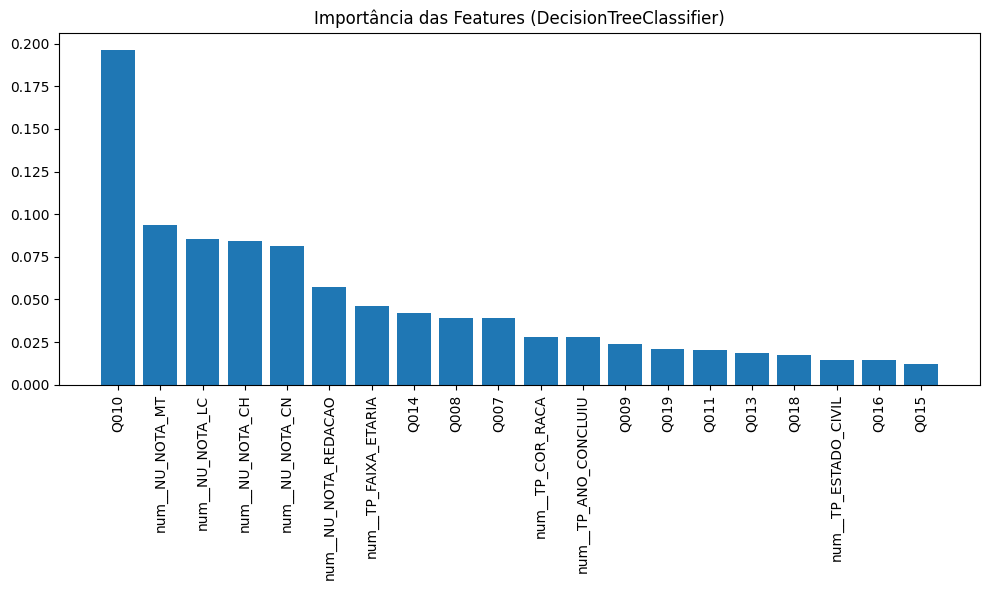

In [26]:
df_importancia_homem = analisar_importancia_features_agregada(modelo_homem, clf_homem, categoricas, 20)

In [27]:
resultado_quartis_dataset_homem = analisar_quartis_por_classe(dataset_homem)


Distribuição de classe social por quartil de notas:

classe_social                   A         B         C       D/E
quartil_notas                                                  
1º Quartil (mais baixo)  0.004885  0.040554  0.310617  0.643944
2º Quartil               0.008852  0.057908  0.362681  0.570559
3º Quartil               0.012968  0.099400  0.458271  0.429361
4º Quartil (mais alto)   0.044611  0.226626  0.474650  0.254113


C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['quartil_notas'] = pd.qcut(dataset['media_notas'], 4,
C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:25: FutureWarning: The default of observed=False is deprecated and will be changed

In [28]:
resultado_modelo_homem = analisar_quartis_com_modelo(modelo_homem, X_homem)


Distribuição da classe prevista pelo modelo em cada quartil de notas:

classe_prevista                 A         B         C       D/E
quartil_notas                                                  
1º Quartil (mais baixo)  0.004885  0.040554  0.310625  0.643936
2º Quartil               0.009091  0.057320  0.354851  0.578739
3º Quartil               0.012968  0.099400  0.458271  0.429361
4º Quartil (mais alto)   0.044611  0.226626  0.474650  0.254113


C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\92591484.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = (df.groupby('quartil_notas')['classe_prevista']


C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\2365023038.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social:
  classe_social       media     mediana        moda  desvio_padrao  \
0             A  622.174698  627.880000  537.777315      91.539885   
1             B  601.007604  598.960000  537.777315      87.925072   
2             C  552.363117  537.777315  537.777315      79.203133   
3           D/E  515.591476  537.777315  537.777315      74.482341   

     variancia  amplitude   coef_var  
0  8379.550553     785.22  14.712891  
1  7730.818337     847.26  14.629611  
2  6273.136326     862.58  14.338961  
3  5547.619134     840.26  14.445999  


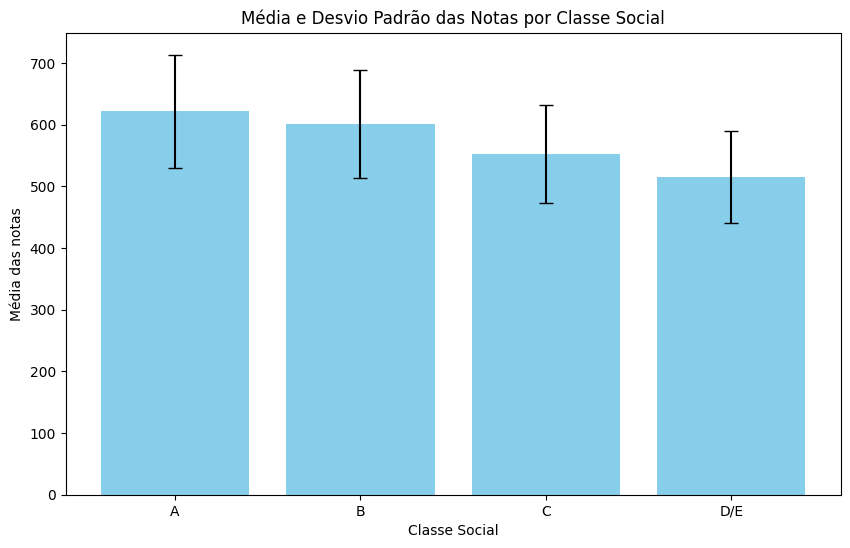

,classe_social,media,mediana,moda,desvio_padrao,variancia,amplitude,coef_var
0,A,622.174698,627.880000,537.777315,91.539885,8379.550553,785.22,14.712891
1,B,601.007604,598.960000,537.777315,87.925072,7730.818337,847.26,14.629611
2,C,552.363117,537.777315,537.777315,79.203133,6273.136326,862.58,14.338961
3,D/E,515.591476,537.777315,537.777315,74.482341,5547.619134,840.26,14.445999


In [65]:
analisar_desempenho_por_classe(dataset_homem)

In [32]:
# 1. Separar X e y
X_mulher = dataset_mulher.drop(columns=['classe_social'])
y_mulher = dataset_mulher['classe_social']

# 2. Identificar colunas categóricas e numéricas
categoricas = ['TP_SEXO', 'Q007','Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019']
numericas = ['TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'TP_ENSINO', 'TP_LOCALIZACAO_ESC',
               'NU_NOTA_CH', 'NU_NOTA_CN', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'TP_FAIXA_ETARIA', 'TP_ANO_CONCLUIU'] 

# 3. Pré-processamento (OneHot para categóricas, passthrough para numéricas)
preprocessador_mulher = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categoricas),
        ('num', 'passthrough', numericas)
    ]
)

clf_mulher = DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=None,          # sem limite de profundidade
    min_samples_split=2,     # pode dividir até com 2 amostras
    min_samples_leaf=1,      # folhas com 1 amostra
    max_features=None,       # usa todos os atributos
    random_state=42
)

# 4. Criar pipeline com pré-processamento + modelo
modelo_mulher = Pipeline(steps=[
    ('preprocessador', preprocessador_mulher),
    ('classificador', clf_mulher) 
])



# 6. Treinar modelo
modelo_mulher.fit(X_mulher, y_mulher)

# 7. Avaliar
y_pred_mulher = modelo_mulher.predict(X_mulher)
print("Acurácia:", accuracy_score(y_mulher, y_pred_mulher))
print("\nRelatório de classificação:\n", classification_report(y_mulher, y_pred_mulher))
print("\nMatriz de confusão:\n", confusion_matrix(y_mulher, y_pred_mulher))

Acurácia: 0.9678303406831081

Relatório de classificação:
               precision    recall  f1-score   support

           A       0.99      1.00      0.99     25144
           B       0.99      0.98      0.98    175429
           C       0.96      0.94      0.95    796484
         D/E       0.97      0.98      0.97   1414128

    accuracy                           0.97   2411185
   macro avg       0.98      0.97      0.98   2411185
weighted avg       0.97      0.97      0.97   2411185


Matriz de confusão:
 [[  25038      32      53      21]
 [    158  172215    2448     608]
 [     80    1690  750010   44704]
 [     13     587   27173 1386355]]


In [35]:
resultado_quartis_dataset_mulher = analisar_quartis_por_classe(dataset_mulher)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC',
C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['quartil_notas'] = pd.qcut(dataset['media_notas'], 4,
C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\983165651.py:25: FutureWarning: The default of observed=False is deprecated and will be changed


Distribuição de classe social por quartil de notas:

classe_social                   A         B         C       D/E
quartil_notas                                                  
1º Quartil (mais baixo)  0.001860  0.019263  0.225127  0.753750
2º Quartil               0.004348  0.034359  0.285840  0.675453
3º Quartil               0.007730  0.068461  0.407284  0.516525
4º Quartil (mais alto)   0.029896  0.190327  0.479197  0.300581


In [36]:
resultado_modelo_mulher = analisar_quartis_com_modelo(modelo_mulher, X_mulher)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\92591484.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tabela = (df.groupby('quartil_notas')['classe_prevista']



Distribuição da classe prevista pelo modelo em cada quartil de notas:

classe_prevista                 A         B         C       D/E
quartil_notas                                                  
1º Quartil (mais baixo)  0.001860  0.019263  0.225129  0.753748
2º Quartil               0.004496  0.033436  0.268708  0.693360
3º Quartil               0.007730  0.068461  0.407284  0.516525
4º Quartil (mais alto)   0.029896  0.190327  0.479197  0.300581


C:\Users\Carlos\AppData\Local\Temp\ipykernel_14008\2365023038.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['media_notas'] = dataset[notas].mean(axis=1)



Resumo estatístico completo por classe social:
  classe_social       media     mediana        moda  desvio_padrao  \
0             A  627.401543  635.260000  537.777315      83.825011   
1             B  610.553428  612.780000  537.777315      82.788032   
2             C  556.767289  537.777315  537.777315      76.653868   
3           D/E  513.678748  537.777315  537.777315      68.222979   

     variancia  amplitude   coef_var  
0  7026.632447     682.00  13.360664  
1  6853.858287     786.00  13.559507  
2  5875.815530     844.46  13.767667  
3  4654.374821     826.30  13.281254  


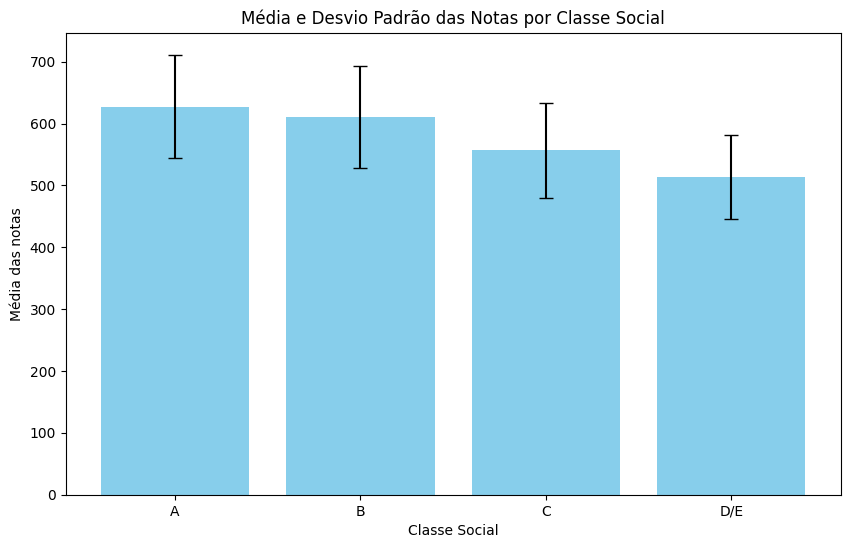

,classe_social,media,mediana,moda,desvio_padrao,variancia,amplitude,coef_var
0,A,627.401543,635.260000,537.777315,83.825011,7026.632447,682.00,13.360664
1,B,610.553428,612.780000,537.777315,82.788032,6853.858287,786.00,13.559507
2,C,556.767289,537.777315,537.777315,76.653868,5875.815530,844.46,13.767667
3,D/E,513.678748,537.777315,537.777315,68.222979,4654.374821,826.30,13.281254


In [66]:
analisar_desempenho_por_classe(dataset_mulher)